# H Impulse Function

Text(0, 0.5, 'Amplitude')

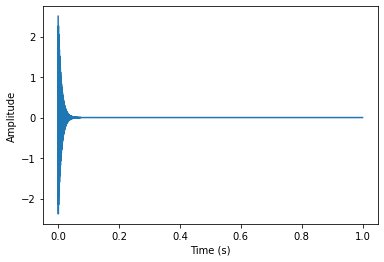

In [10]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import sympy as sp
from scipy import signal
import scipy
from numpy import meshgrid, linspace
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline



import numpy as np 
from matplotlib import pyplot as plt
FS = 0
speed=30

def generate_time(number_of_points,sampling_frequency):
    t = np.linspace(0,number_of_points/sampling_frequency-1/sampling_frequency,number_of_points)
    return t

# Sampling frequency [Hz]
fs1 = 30  # Hz
fs2 = 2.5 # Hz
fs3 = 1.4 # Hz

# Number of samples in the time vector: 
N = 2000000
t1 = generate_time(N,fs1)
t2 = generate_time(N,fs2)
t3 = generate_time(N,fs3)


fs=20000
t = np.arange(0,1,1/fs)

def h_function(t,natural_frequency):
    natural_frequencies = 1000 

    h = np.exp(-100*t) *np.cos(2 * np.pi * t*natural_frequencies) * 2.5

    fs = 20000
    t = np.arange(0,1,1/fs)

    return h
plt.plot(t,h_function(t,1000))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


# Speed & Noise

In [11]:
def M(speed):
    x=speed**2
    return x

def M_noise(speed):
    e=np.random.normal(0,1,20000)
    return   M(speed)*e


# Time of Arrival Function

Period of impulses in rad: 1.5707963267948966
Period of impulses in rot: 0.25
BPFO/Speed: 4.0


Text(0.5, 0, 'Time s')

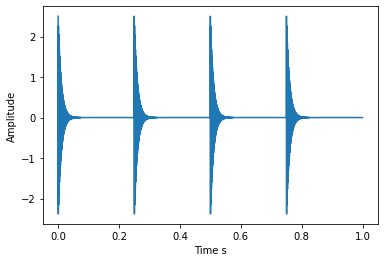

In [12]:
import numpy as np 
from matplotlib import pyplot as plt

def time_of_arrival_time_varying(t,speedRadPS,phaseBearingRad):
    
    if speedRadPS.shape[0] != len(t):
        raise ValueError("Both t and speedRadPS need to have the same shape.")
        
    phaseOfShaftRad = np.zeros(len(t))
    phaseOfShaftRad[1:] = np.cumsum(np.array([0.5*(speedRadPS[idx+1] + speedRadPS[idx])*(t[idx+1] - t[idx]) for idx in range(len(t)-1) ]))

    import scipy.interpolate as sciint

    phaseOfImpulsesRad = np.arange(phaseOfShaftRad.min(),phaseOfShaftRad.max(),phaseBearingRad)

    f_int = sciint.interp1d(phaseOfShaftRad,t,kind="linear")
    
    time_of_arrival = f_int(phaseOfImpulsesRad)
    
    d = np.zeros(len(t))
    for tof in time_of_arrival:
        
        d[np.argmin(np.abs(t - tof))] = 1.0
    
    return time_of_arrival,d

x=h_function(t,1000)
speedRadPS=1*np.ones(len(t))*2*np.pi
period_impulses_rad = 0.5*np.pi


print("Period of impulses in rad:",period_impulses_rad)
print("Period of impulses in rot:",period_impulses_rad/(2*np.pi))
print("BPFO/Speed:",1/(period_impulses_rad/(2*np.pi)))
tof,d = time_of_arrival_time_varying(t,speedRadPS,period_impulses_rad)


import scipy.signal as scisig
z = scisig.convolve(d,x)[np.arange(len(t))]
plt.plot(t,z)
plt.ylabel('Amplitude')
plt.xlabel('Time s')


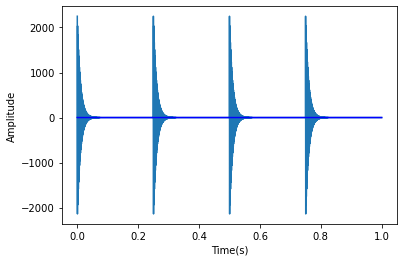

In [13]:
Mb1 = M(speed) 
x_blo1=Mb1*(z)
plt.plot(t,x_blo1)
plt.ylabel('Amplitude')
plt.xlabel('Time(s)')
plt.plot(t,d,'b-')

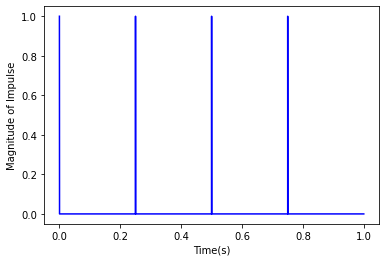

In [14]:
plt.figure(1)
plt.ylabel('Magnitude of Impulse')
plt.xlabel('Time(s)')
plt.plot(t,d,'b-')

# Simulated Bearing Measured Signal at Fault Severity=0(Healthy)

(array([1741.03146751, -561.7129783 , -549.12629322, ...,  814.04328469,
       1061.76934382, -433.97672604]), array([0., 0., 0., ..., 0., 0., 0.]))


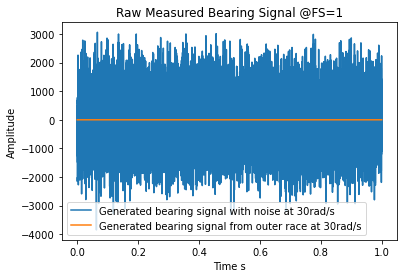

In [15]:
def meas_sig2(t,speed,FS):
    
    Mb = M(speed)    
    


    h = h_function(t,1000)    
    
    # Sum of dirac deltas: 
    d = time_of_arrival_time_varying(t,speedRadPS,period_impulses_rad) 

    Mn = M_noise(speed)
    
    x_blo=Mb*(z)  #should this be dot product or vector multiplaction?


    
    x_blo = (x_blo*(FS) )
    
    #FS=2
    x_meas=x_blo+ (Mn)#dot product or vector multiplication????
    
    
    return x_meas,x_blo

print(meas_sig2(t,speed,FS))
plt.plot(t,meas_sig2(t,speed,FS)[0], label='Generated bearing signal with noise at 30rad/s')
plt.plot(t,meas_sig2(t,speed,FS)[1], label='Generated bearing signal from outer race at 30rad/s')
plt.xlabel('Time s')
plt.ylabel('Amplitude')
plt.title('Raw Measured Bearing Signal @FS=1')

plt.legend()




# Condition Indicators First Set

## KUCR

6382757836.552961


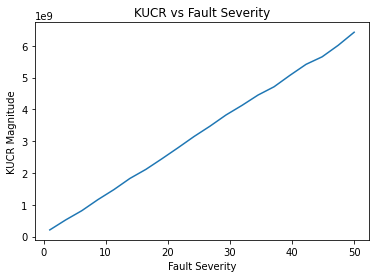

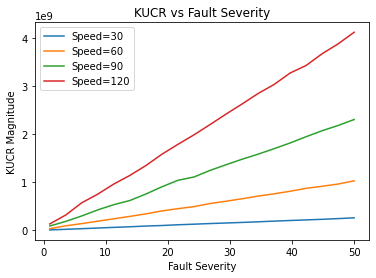

In [9]:
def kurt(x):
    
    x = x - np.mean(x)
    return np.mean(x**4)/np.mean(x**2)**2

a=kurt(meas_sig2(t,speed,FS)[0])


def crest_factor(x):
    return np.max(np.abs(x))/np.sqrt(np.mean(np.square(x)))

b=crest_factor(meas_sig2(t,speed,FS)[0])

def rms(x):
    return np.sqrt(np.mean(x**2))

c=rms(meas_sig2(t,speed,FS)[0])




def kucr(FS):
    t = np.arange(0,1,1/fs)
    speed=30
    a=kurt(meas_sig2(t,speed,FS)[0])
    b=crest_factor(meas_sig2(t,speed,FS)[0])
    c=rms(meas_sig2(t,speed,FS)[0])
    
    return np.sqrt( (a**2) + (b*c)**2 )

print(kucr(meas_sig2(t,speed,FS)[0]))

FSkucr = np.linspace(1,50,20)

featkucr = []
for FS in FSkucr:
    featkucr.append(kucr(meas_sig2(t,speed,FS)[0]))

plt.plot(FSkucr,featkucr)
plt.title('KUCR vs Fault Severity')
plt.figure(1)
plt.xlabel('Fault Severity')
plt.ylabel('KUCR Magnitude')

def plotKUCR():
    
    for i in np.array([30,60,90,120]):
        featrmsGOAT=[]
        for FS in FSkucr:
            featrmsGOAT.append(kucr(meas_sig2(t,i,FS)[0]))
            lb='Speed={}'
        plt.figure(4)
        plt.title('KUCR vs Fault Severity')
        plt.plot(FSkucr,featrmsGOAT,label=lb.format(i))
        plt.xlabel('Fault Severity')
        plt.ylabel('KUCR Magnitude')
        plt.legend()
        
plotKUCR()

## Gini Index

0.028695350804337848


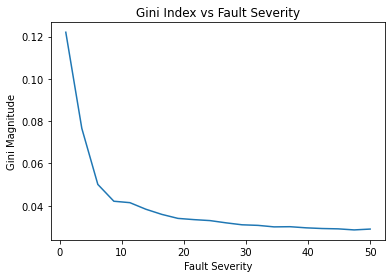

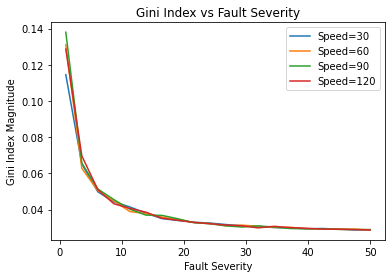

In [10]:
import numpy as np

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

print(gini(meas_sig2(t,speed,FS)[0]))
FSgini= np.linspace(1,50,20)

featgini = []
for FS in FSgini:
    featgini.append(gini(meas_sig2(t,speed,FS)[0]))

plt.plot(FSgini,featgini)
plt.title('Gini Index vs Fault Severity')
plt.figure(1)
plt.xlabel('Fault Severity')
plt.ylabel('Gini Magnitude')



def plotg():
    
    for i in np.array([30,60,90,120]):
        featrmsGOAT=[]
        for FS in FSgini:
            featrmsGOAT.append(gini(meas_sig2(t,i,FS)[0]))
            lb='Speed={}'
        plt.figure(4)
        plt.title('Gini Index vs Fault Severity')
        plt.plot(FSgini,featrmsGOAT,label=lb.format(i))
        plt.xlabel('Fault Severity')
        plt.ylabel('Gini Index Magnitude')
        plt.legend()
        
plotg()


# RMS

In [14]:
def rms(x):
    return np.sqrt(np.mean(x**2))

FSs = np.linspace(1,50,20)

featrms = []
for FS in FSs:
    featrms.append(rms(meas_sig2(t,speed,FS)[0]))

plt.plot(FSs,featrms)
plt.title('RMS vs Fault Severity')
plt.figure(1)
plt.xlabel('Fault Severity')
plt.ylabel('RMS Magnitude')

speeds=1
speeds = np.linspace(1,120,20)
featrms2 = []
for speed in speeds:
    featrms2.append(rms(meas_sig2(t,speed,FS)[0]))

plt.figure(2)
plt.title('RMS vs Speed')
plt.plot(speeds,featrms2,color='red')
plt.xlabel('Speed rad/s')
plt.ylabel('RMS Magnitude')

def plotRMS():
    
    for i in np.array([0,5,10,20]):
        featrmsGOAT=[]
        for speed in speeds:
            featrmsGOAT.append(rms(meas_sig2(t,speed,i)[0]))
            lb='Fs={}'
        plt.figure(3)
        plt.title('RMS vs Speed')
        plt.plot(speeds,featrmsGOAT,label=lb.format(i))
        plt.xlabel('Speed rad/s')
        plt.ylabel('RMS Magnitude')
        plt.legend()
        
plotRMS()

FSrms = np.linspace(1,50,20)

def plotRMS2():
     for j in np.array([30,60,90,120]):
        featrmsGOAT=[]
        for FS in FSrms:
            featrmsGOAT.append(rms(meas_sig2(t,j,FS)[0]))
            lb='Speed={}'
        plt.figure(4)
        plt.title('RMS vs Fault Severity')
        plt.plot(FSrms,featrmsGOAT,label=lb.format(j))
        plt.xlabel('Fault Severity')
        plt.ylabel('RMS Magnitude')
        plt.legend()
        
plotRMS2()
    
        


ValueError: operands could not be broadcast together with shapes (5,) (20000,) 

# Crest Factor

In [ ]:
import numpy as np
def crest_factor(x):
    return np.max(np.abs(x))/np.sqrt(np.mean(np.square(x)))


FSv = np.linspace(1,50,20)

feat = []
for FS in FSv:
    feat.append(crest_factor(meas_sig2(t,speed,FS)[0]))

plt.plot(FSv,feat)
plt.title('Crest Factor vs Fault Severity')
plt.figure(1)
plt.xlabel('Fault Severity')
plt.ylabel('Crest Factor Magnitude')


speed=1
speedv = np.linspace(1,120,20)
feat1 = []
for speed in speedv:
    feat1.append(crest_factor(meas_sig2(t,speed,FS)[0]))

plt.figure(2)
plt.title('Crest Factor vs Speed at a FS=1')
plt.plot(speedv,feat1,color='green')
plt.xlabel('Speed')
plt.ylabel('Crest Factor Magnitude')

def plotCREST():
    
    for i in np.array([0,5,10,20]):
        featrmsGOAT=[]
        for speed in speedv:
            featrmsGOAT.append(crest_factor(meas_sig2(t,speed,i)[0]))
            lb='Fs={}'
        plt.figure(3)
        plt.title('Crest Factor vs Speed at a FS=1')
        plt.plot(speedv,featrmsGOAT,label=lb.format(i))
        plt.xlabel('Speed')
        plt.ylabel('Crest Factor Magnitude')
        plt.legend()
        
plotCREST()

def plotCF2():
     for j in np.array([30,60,90,120]):
        featrmsGOAT=[]
        for FS in FSv:
            featrmsGOAT.append(crest_factor(meas_sig2(t,j,FS)[0]))
            lb='Speed={}'
        plt.figure(4)
        plt.title('Crest Factor vs Fault Severity')
        plt.plot(FSv,featrmsGOAT,label=lb.format(j))
        plt.xlabel('Fault Severity')
        plt.ylabel('Crest Factor Magnitude')
        plt.legend()
        
plotCF2()

# Kurtosis

In [ ]:
def kurt(x):
    
    x = x - np.mean(x)
    return np.mean(x**4)/np.mean(x**2)**2

FSv3 = np.linspace(1,50,20)

feat3 = []
for FS in FSv3:
    feat3.append(kurt(meas_sig2(t,speed,FS)[0]))
    
plt.plot(FSv3,feat3)
plt.xlabel('Fault Severity')
plt.ylabel('Kurtosis Magnitude')


speed=1
speedv = np.linspace(1,120,20)
feat_3=[]
for speed in speedv:
    feat_3.append(kurt(meas_sig2(t,speed,FS)[0]))

plt.figure(2)
plt.title('Kurtosis vs Speed at a FS=1')
plt.plot(speedv,feat_3,color='brown')
plt.xlabel('Speed')
plt.ylabel('Kurtosis Magnitude')

def plotKURTOSIS():
    
    for i in np.array([0,5,10,20]):
        featrmsGOAT=[]
        for speed in speedv:
            featrmsGOAT.append(kurt(meas_sig2(t,speed,i)[0]))
            lb='Fs={}'
        plt.figure(3)
        plt.title('Kurtosis vs Speed at a FS=1')
        plt.plot(speedv,featrmsGOAT,label=lb.format(i))
        plt.xlabel('Speed')
        plt.ylabel('Kurtosis Magnitude')
        plt.legend()
        
plotKURTOSIS()

def plotk():
     for j in np.array([30,60,90,120]):
        featrms1GOAT=[]
        for FS in FSv3:
            featrms1GOAT.append(kurt(meas_sig2(t,j,FS)[0]))
            lb='Speed={}'
        plt.figure(4)
        plt.title('Kurtosis vs Fault Severity')
        plt.plot(FSv3,featrms1GOAT,label=lb.format(j))
        plt.xlabel('Fault Severity')
        plt.ylabel('Kurtosis Magnitude')
        plt.legend()
        
plotk()

# Peak to Peak

In [ ]:
FSv2 = np.linspace(0,50,20)
def peak_peak(x):
    return max(x)-min(x)



feat2 = []
for FS in FSv2:
    feat2.append(peak_peak(meas_sig2(t,speed,FS)[0]))
plt.figure(1)
plt.plot(FSv2,feat2)
plt.xlabel('Fault Severity')
plt.ylabel('Peak to Peak Magnitude')

speed=1
speedv = np.linspace(1,120,20)
feat_2=[]
for speed in speedv:
    feat_2.append(peak_peak(meas_sig2(t,speed,FS)[0]))

plt.figure(2)
plt.plot(speedv,feat_2,color='purple')
plt.xlabel('Speed rad/s')
plt.ylabel('Peak to Peak Magnitude')

def plotPEAK():
    
    for i in np.array([0,5,10,20]):
        featrmsGOAT=[]
        for speed in speeds:
            featrmsGOAT.append(peak_peak(meas_sig2(t,speed,i)[0]))
            lb='Fs={}'
        plt.figure(3)
        plt.title('Peak to peak vs Speed')
        plt.plot(speeds,featrmsGOAT,label=lb.format(i))
        plt.xlabel('Speed rad/s')
        plt.ylabel('Peak to Peak Magnitude')
        plt.legend()
        
plotPEAK()

def plotPEAK1():
     for j in np.array([30,60,90,120]):
        featrms1GOAT=[]
        for FS in FSv2:
            featrms1GOAT.append(peak_peak(meas_sig2(t,j,FS)[0]))
            lb='Speed={}'
        plt.figure(4)
        plt.title('Peak to Peak vs Fault Severity')
        plt.plot(FSv3,featrms1GOAT,label=lb.format(j))
        plt.xlabel('Fault Severity')
        plt.ylabel('Peak-Peak Magnitude')
        plt.legend()
        
plotPEAK1()

In [ ]:

def kurt(x):
    
    x = x - np.mean(x)
    return np.mean(x**4)/np.mean(x**2)**2

a=kurt(meas_sig2(t,speed,FS)[0])


def crest_factor(x):
    return np.max(np.abs(x))/np.sqrt(np.mean(np.square(x)))

b=crest_factor(meas_sig2(t,speed,FS)[0])

def rms(x):
    return np.sqrt(np.mean(x**2))

c=rms(meas_sig2(t,speed,FS)[0])

def kucr(x):
    
    return np.sqrt( (a**2) + (b*c)**2 )

d=kucr(meas_sig2(t,speed,FS)[0])

print(d)



# Signal Processing 

[   0.44772807    2.66103602    7.98262162 ... -174.75125805  -71.20215696
   33.38255242]


Text(0.5, 1.0, 'Filtered Measured Bearing Signal @FS=1')

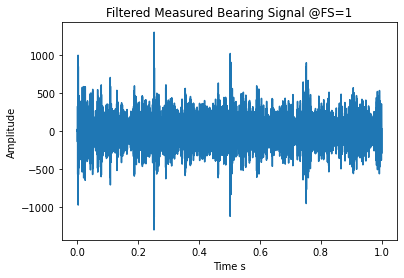

In [13]:
def bandpassFilterButter(x, fs, fl, fh, order=3):
    '''
        Standard bandpass filter. Be careful to use large orders to avoid nans
    '''
    nyq = 0.5 * fs
    low = fl / nyq
    high = fh / nyq
    b, a = scisig.butter(order, [low, high], btype='band')
    y=meas_sig2(t,speed,FS)[0]
    y = scisig.lfilter(b, a, x)
    return y

fs=20000    
xb2 = bandpassFilterButter(meas_sig2(t,speed,FS)[0],20000,1100, 1500 , order=3)



print(xb2)
plt.plot(t,xb2)
plt.xlabel('Time s')
plt.ylabel('Amplitude')
plt.title('Filtered Measured Bearing Signal @FS=1')








# Kurtosis & Spectrogram

[[1.75417255e-02 2.16263865e-03 1.73104993e-02 ... 2.75636078e-03
  1.98613027e-03 3.11362166e-02]
 [8.75941781e-03 1.07854017e-03 8.65447978e-03 ... 1.37530113e-03
  9.88619658e-04 1.55392283e-02]
 [1.84483350e-09 9.23256439e-10 2.96516288e-10 ... 1.94398781e-11
  3.37087875e-09 3.47098519e-09]
 ...
 [1.19418724e-14 4.23136475e-17 6.76495408e-15 ... 5.42737620e-16
  9.90217265e-16 8.51746769e-15]
 [1.19135747e-14 3.91131099e-17 6.70504544e-15 ... 5.21686702e-16
  1.00556815e-15 8.43357414e-15]
 [5.96047420e-15 1.90728377e-17 3.35074387e-15 ... 2.68182758e-16
  4.86829315e-16 4.23643456e-15]]


Text(0, 0.5, 'Freq')

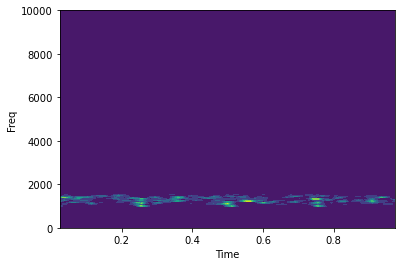

In [14]:
import scipy.io as sio
import pandas as pd 
import scipy.signal as scisig
import numpy as np
import matplotlib.pyplot as plt


Lnum = 10
Nw = int(2**int(Lnum))

# scisig.spectrogram?
Fxx,Txx,Sxx = scisig.spectrogram(xb2, fs=20000, window="hann", nperseg=int(Nw), noverlap=int(Nw*0.75), nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')

import pywt
print(Sxx)
plt.figure(1)
plt.contourf(Txx,Fxx,Sxx)
plt.xlabel("Time")
plt.ylabel("Freq")

# Spectral Skewness

Text(0, 0.5, 'Skewness Magnitude')

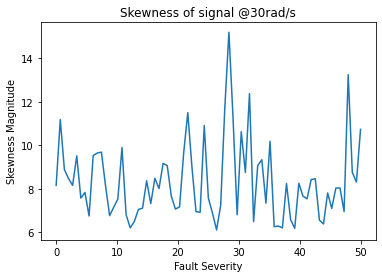

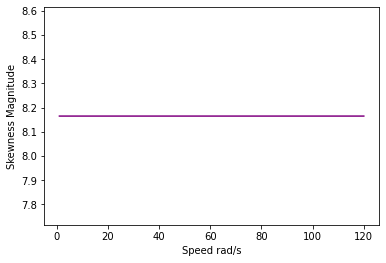

In [17]:
from scipy.stats import skew

FSskew=np.linspace(0,50,75)
for FS in FSskew:
    xskew=skew(Sxx)
plt.plot(FSskew,xskew)
plt.title('Skewness of signal @30rad/s')
plt.xlabel('Fault Severity')
plt.ylabel('Skewness Magnitude')

speed=1
speedv = np.linspace(1,120,20000)
feat_skew=[]
for speed in speedv:
    feat_skew.append(skew(Sxx)[0])

plt.figure(2)
plt.plot(speedv,feat_skew,color='purple')
plt.xlabel('Speed rad/s')
plt.ylabel('Skewness Magnitude')

# Spectral Entropy

In [ ]:
import numpy as np
import antropy as ant

xentropy=ant.spectral_entropy(Sxx, sf=20000, method='welch', normalize=True)
FSentropy=np.linspace(0,50,513)
for FS in FSentropy:
    xskew=skew(Sxx)
plt.plot(FSentropy,xentropy)
plt.title('Skewness of signal @30rad/s')
plt.xlabel('Fault Severity')
plt.ylabel('Entropy Magnitude')


# Envelope Spectrum

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

analytic_signal = hilbert(xb2)
amplitude_envelope = np.abs(analytic_signal)
print(amplitude_envelope)

plt.plot(t, amplitude_envelope, label='envelope',color='r')
plt.xlabel('Time s')
plt.ylabel('Magnitude')
plt.show()
np.shape(amplitude_envelope)